In [24]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import tensorflow as tf
from scipy.signal import savgol_filter
from scipy.signal import find_peaks

from sklearn.model_selection import train_test_split
import sklearn
import keras
from keras.models import Sequential
from keras.layers import Dense
import tensorflow as tf
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, GlobalAveragePooling1D, Dense
import tsaug

In [25]:
windows = np.load('windows.npy')
labels = np.load('labels.npy')

In [26]:
num_classes = 8

In [27]:
model_CNN = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(windows.shape[1], windows.shape[2])),  # (window_size, 3)
    tf.keras.layers.Conv1D(64, kernel_size=3, activation='relu', padding='same'),
    tf.keras.layers.MaxPooling1D(pool_size=2),
    tf.keras.layers.Conv1D(128, kernel_size=3, activation='relu' , padding='same'),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(num_classes, activation='softmax')  # 8 classes
])

model_CNN.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',  # since y_train is integer labels (0–7)
    metrics=['accuracy']
)

model_CNN.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d_4 (Conv1D)                    │ (None, 3, 64)               │             448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_2 (MaxPooling1D)       │ (None, 1, 64)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_5 (Conv1D)                    │ (None, 1, 128)              │          24,704 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling1d_2           │ (None, 128)                 │               0 │
│ (GlobalAveragePooling1D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 8)                   │             520 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 33,928 (132.53 KB)

 Trainable params: 33,928 (132.53 KB)

 Non-trainable params: 0 (0.00 B)

In [28]:
X_train, X_val, y_train, y_val = train_test_split(windows, labels, test_size=0.2, random_state=42, stratify=labels)

In [29]:
history = model_CNN.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=19,
    batch_size=64,
    callbacks=[tf.keras.callbacks.EarlyStopping(patience=3, restore_best_weights=True)],
    shuffle=True  # optional but recommended
)

Epoch 1/19
18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - accuracy: 0.6251 - loss: 1.4008 - val_accuracy: 0.7812 - val_loss: 0.8600
Epoch 2/19
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.8041 - loss: 0.7574 - val_accuracy: 0.7812 - val_loss: 0.8067
Epoch 3/19
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.7749 - loss: 0.8076 - val_accuracy: 0.7812 - val_loss: 0.7974
Epoch 4/19
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.7911 - loss: 0.7850 - val_accuracy: 0.7812 - val_loss: 0.7830
Epoch 5/19
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.7805 - loss: 0.7841 - val_accuracy: 0.7951 - val_loss: 0.7651
Epoch 6/19
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.7981 - loss: 0.7321 - val_accuracy: 0.8056 - val_loss: 0.7419
Epoch 7/19
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.7906 - loss: 0.7446 - val_accuracy: 0.8194 - val_loss: 0.7023
Epoch 8/19
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.8299 - loss: 0.6762 - val_accuracy: 0.8264 - val_los

In [30]:
test_loss_CNN, test_acc_CNN = model_CNN.evaluate(X_val, y_val, batch_size=64)
print(f"Validation accuracy: {test_acc_CNN:.2f}")

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.8990 - loss: 0.3511
Validation accuracy: 0.90


In [31]:
predsCNN = model_CNN.predict(X_val)  # shape = (num_samples, 8)
predicted_labelsCNN = predsCNN.argmax(axis=1)

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step  


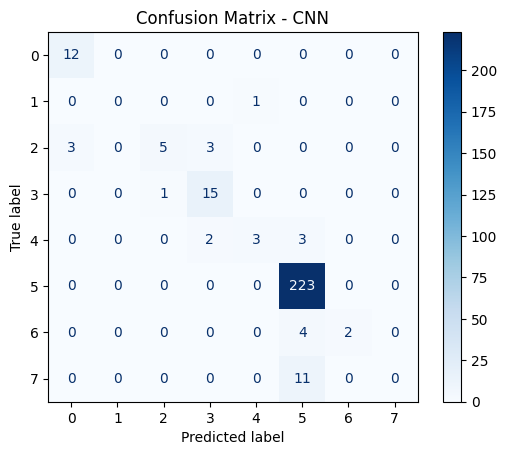

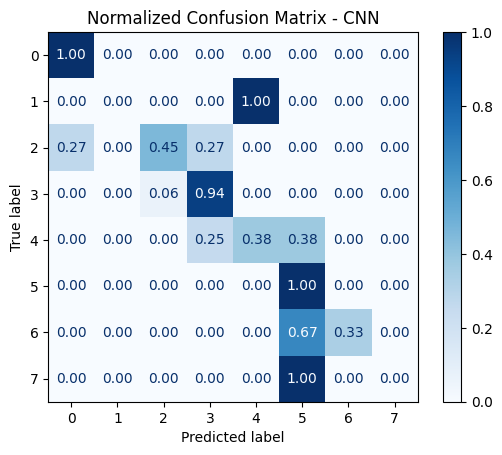

In [32]:
cm = confusion_matrix(y_val, predicted_labelsCNN, labels=np.arange(num_classes))

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.arange(8))
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix - CNN")
plt.show()

cm = confusion_matrix(y_val, predicted_labelsCNN, labels=np.arange(num_classes))

row_sum = cm.sum(axis=1, keepdims=True)
row_sum[row_sum == 0] = 1

cm_normalized = cm.astype('float') / row_sum

disp = ConfusionMatrixDisplay(confusion_matrix=cm_normalized, display_labels=np.arange(num_classes))
disp.plot(cmap=plt.cm.Blues, values_format=".2f")  # shows values with 2 decimal places
plt.title("Normalized Confusion Matrix - CNN")
plt.show()

In [33]:
converter = tf.lite.TFLiteConverter.from_keras_model(model_CNN)
tflite_CNN_model = converter.convert()
open("model_CNN.tflite", "wb").write(tflite_CNN_model)

INFO:tensorflow:Assets written to: C:\Users\jonat\AppData\Local\Temp\tmp1cz757je\assets


INFO:tensorflow:Assets written to: C:\Users\jonat\AppData\Local\Temp\tmp1cz757je\assets


Saved artifact at 'C:\Users\jonat\AppData\Local\Temp\tmp1cz757je'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 3, 2), dtype=tf.float32, name='keras_tensor_14')
Output Type:
  TensorSpec(shape=(None, 8), dtype=tf.float32, name=None)
Captures:
  1293605007632: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1293727541456: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1293727541072: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1293727544912: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1293727544336: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1293727542032: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1293727545680: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1293727542224: TensorSpec(shape=(), dtype=tf.resource, name=None)


140508

In [34]:
model_CNN.export("model_CNN")

INFO:tensorflow:Assets written to: model_CNN\assets


INFO:tensorflow:Assets written to: model_CNN\assets


Saved artifact at 'model_CNN'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 3, 2), dtype=tf.float32, name='keras_tensor_14')
Output Type:
  TensorSpec(shape=(None, 8), dtype=tf.float32, name=None)
Captures:
  1293605007632: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1293727541456: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1293727541072: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1293727544912: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1293727544336: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1293727542032: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1293727545680: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1293727542224: TensorSpec(shape=(), dtype=tf.resource, name=None)
